In [18]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

df = pd.read_csv("diabetes.csv")
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
112,1,89,76,34,37,31.2,0.192,23,0
197,3,107,62,13,48,22.9,0.678,23,1
116,5,124,74,0,0,34.0,0.220,38,1
149,2,90,70,17,0,27.3,0.085,22,0
234,3,74,68,28,45,29.7,0.293,23,0


In [19]:
X = df.drop(['Outcome'], axis = 1)
Y = df.Outcome.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [20]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
len(X_train[0])

8

In [22]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)

In [51]:
train_ds = TensorDataset(X_train_t, Y_train_t)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)

# Define the neural network (13 → 32 → 16 → 16 → 1 with sigmoid)
class HeartNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = HeartNet()

criterion = nn.BCELoss()          # binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
print(model)

HeartNet(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): ReLU()
    (10): Linear(in_features=8, out_features=4, bias=True)
    (11): ReLU()
    (12): Linear(in_features=4, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [53]:
num_epochs = 60

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, loss = {epoch_loss:.4f}")

Epoch 10/60, loss = 0.4581
Epoch 20/60, loss = 0.4306
Epoch 30/60, loss = 0.3842
Epoch 40/60, loss = 0.3260
Epoch 50/60, loss = 0.2741
Epoch 60/60, loss = 0.2306


In [54]:
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()

y_pred[0:10]

array([0.99999166, 0.07040327, 0.03087833, 0.88826776, 0.04056902,
       0.00650015, 0.998276  , 0.93698025, 0.9957942 , 0.05134579],
      dtype=float32)

In [55]:
y_pred = y_pred.round()
y_pred[0:10]

array([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], dtype=float32)

accuracy of the model:  0.7597402597402597


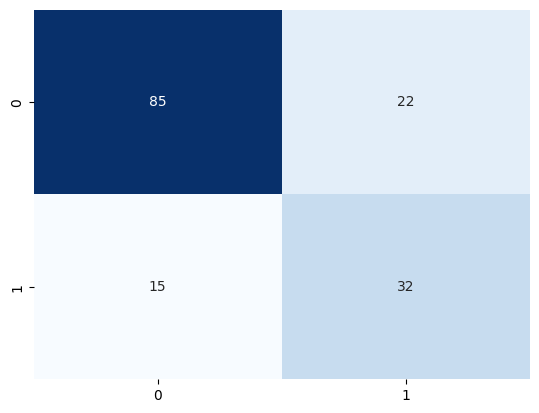

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(Y_test, y_pred.round())
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

ac = accuracy_score(Y_test, y_pred.round())
print('accuracy of the model: ', ac)